# 1.Librerías

In [1]:
%pip install lightgbm==4.4.0
%pip install optuna==3.6.1


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\mconde\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\mconde\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

# 2.Datos

In [ ]:
#seteo carpeta de trabajo y archivo
# dataset_path = '/home/ingceciliaconde/buckets/b1/datasets'
# modelos_path = '/home/ingceciliaconde/buckets/b1/datasets/modelos'
# db_path = '/home/ingceciliaconde/buckets/b1/datasets/db'
# exp_path ='/home/ingceciliaconde/buckets/b1/exp'
# dataset_file = 'competencia_02.csv.gz'


In [2]:
#path de trabajo local para pruebas
#seteo carpeta de trabajo y archivo
dataset_path = 'C:/Users/mconde/Documents/DMEYF/Competencia_01'
db_path = 'C:/Users/mconde/Documents/DMEYF/Competencia_01'
modelos_path = 'C:/Users/mconde/Documents/DMEYF/Competencia_01'
dataset_file = 'competencia_01.csv'


In [3]:
print(f"{dataset_path}/{dataset_file}")



C:/Users/mconde/Documents/DMEYF/Competencia_01/competencia_01.csv


In [4]:
# Lectura de datos.
data= pd.read_csv(f"{dataset_path}/{dataset_file}")


In [5]:
#semillas y valores de ganancia
semillas=[100183,200003,300017,700001,800011]
ganancia_acierto = 273000
costo_estimulo = 7000

In [6]:
#meses
mes_train_all = [201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908,
                 201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004,
                 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106]

mes_train_6 = [202101, 202102, 202103, 202104, 202105, 202106]
mes_train_12 = [202006, 202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106]
mes_test = 202108

In [7]:
mes_train=mes_train_6 #si uso 6 meses, cambiar a mes_train_6 y si uso all, cambiar a mes_train_all

## Darle valor a las clases

In [8]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

En particular, sumaremos la clase BAJA+1, que es estructuralmente muy similar a BAJA+2, para aumentar los casos positivos. Luego, compararemos los resultados obtenidos con los de la clase con la que hemos estado trabajando hasta ahora.

In [9]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0) # solo baja +2
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1) #ambas bajas

In [11]:
#filtrar por baja + 2 y mostrar clase ternaria clase binaria
data[data['clase_ternaria'] == 'BAJA+2'][['clase_ternaria', 'clase_binaria1', 'clase_binaria2']].head()


,clase_ternaria,clase_binaria1,clase_binaria2
1047,BAJA+2,1,1
1651,BAJA+2,1,1
1870,BAJA+2,1,1
1920,BAJA+2,1,1
2039,BAJA+2,1,1


# 3.Separa Test y Train

In [12]:
train_data = data[data['foto_mes'].isin(mes_train)] # train_data = data[data['foto_mes'] == mes_train]
#test_data = data[data['foto_mes'] == mes_test]
test_data = data[data['foto_mes'] == 202106] #solo para hacer el script, en la competencia se usará 202108

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1'] #SOLO BAJA+2
y_train_binaria2 = train_data['clase_binaria2'] #TODAS LAS BAJAS
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

# 4.Funcion de Ganancia

In [13]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelos.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

# 5.Optimizacion del Modelo


In [17]:
#optimizacion de hiperparametros
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 100),
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3), # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 50, 2000), #cambie de 1 a 50
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=1000, # modificar, subit y subir... y descomentar la línea inferior
        callbacks=[lgb.early_stopping(stopping_rounds=int(50 + 5 / learning_rate[0]))],
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    
    # Calculo la ganancia máxima y la mejor iteración donde se obtuvo dicha ganancia.
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5



In [18]:
#almacenamiento de los resultados
storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = "exp_lgbm_v1"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-11-17 19:04:13,338] Using an existing study with name 'exp_lgbm_v1' instead of creating a new one.


In [19]:
study.optimize(objective, n_trials=100) # subir subir

Training until validation scores don't improve for 87 rounds
Early stopping, best iteration is:
[1]	cv_agg's valid gan_eval: -7000 + 0


[I 2024-11-17 19:06:00,043] Trial 22 finished with value: -35000.0 and parameters: {'num_leaves': 66, 'learning_rate': 0.13477968241431998, 'min_data_in_leaf': 1927, 'feature_fraction': 0.32019629088545565, 'bagging_fraction': 0.7515678420009526}. Best is trial 10 with value: 2590000.0.


Training until validation scores don't improve for 68 rounds


[W 2024-11-17 19:06:17,185] Trial 23 failed with parameters: {'num_leaves': 100, 'learning_rate': 0.26672769001015123, 'min_data_in_leaf': 54, 'feature_fraction': 0.1775350181925592, 'bagging_fraction': 0.15755587798735998} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\mconde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\mconde\AppData\Local\Temp\ipykernel_18060\1728026816.py", line 29, in objective
    cv_results = lgb.cv(
                 ^^^^^^^
  File "C:\Users\mconde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\engine.py", line 827, in cv
    res = _agg_cv_result(cvfolds.eval_valid(feval))  # type: ignore[call-arg]
          

KeyboardInterrupt: 

## 5.1 Analisis de la optimizacion

In [ ]:
optuna.visualization.plot_optimization_history(study)


In [ ]:
plot_param_importances(study)

In [ ]:
plot_slice(study)

In [ ]:
plot_contour(study)

In [ ]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

# 7.Entrenamiento

---

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [ ]:
cantidad_meses_train = 12  # Ejemplo: 6 meses para atrás desde 06/2021
ventana = 3
semillas=[100183,200003,300017,700001,800011]

In [34]:
# parametros de mejor modelo 
best_params = study.best_params
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
print(f"Mejores parámetros para el mejor modelo {best_params}")

Mejor cantidad de árboles para el mejor model 3
Mejores parámetros para el mejor modelo {'num_leaves': 74, 'learning_rate': 0.20998094578508172, 'min_data_in_leaf': 354, 'feature_fraction': 0.1413714678049873, 'bagging_fraction': 0.6124884045180642}


In [ ]:
from tqdm import tqdm  # Importar tqdm
# Preparamos el conjunto de datos
train_data = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train)

# Bucle para entrenar un modelo para cada semilla y guardar cada modelo
for semilla in semillas:
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': study.best_trial.params['num_leaves'],
        'learning_rate': study.best_trial.params['learning_rate'],
        'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
        'feature_fraction': study.best_trial.params['feature_fraction'],
        'bagging_fraction': study.best_trial.params['bagging_fraction'],
        'seed': semilla,  # Usar la semilla actual del bucle
        'verbose': 0
    }
  # Entrenar el modelo con los parámetros actuales
    model_lgb = lgb.train(params,train_data, num_boost_round=best_iter)

 # Construir el nombre del archivo con la semilla, cantidad de meses y ventana
    model_filename = f'lgb_v5_semilla{semilla}_{cantidad_meses_train}_{ventana}.txt'
    #dataset_out = modelos_path +'/'+ model_filename
    dataset_out = dataset_path +'/'+ model_filename
    
    # Guardar el modelo en un archivo
    model_lgb.save_model(dataset_out)
    print(f'Modelo entrenado con semilla {semilla} y guardado en {dataset_out}')


Modelo entrenado con semilla 100183 y guardado en C:/Users/mconde/Documents/DMEYF/Competencia_01/lgb_v5_semilla100183_6_3.txt
Modelo entrenado con semilla 200003 y guardado en C:/Users/mconde/Documents/DMEYF/Competencia_01/lgb_v5_semilla200003_6_3.txt
Modelo entrenado con semilla 300017 y guardado en C:/Users/mconde/Documents/DMEYF/Competencia_01/lgb_v5_semilla300017_6_3.txt
Modelo entrenado con semilla 700001 y guardado en C:/Users/mconde/Documents/DMEYF/Competencia_01/lgb_v5_semilla700001_6_3.txt
Modelo entrenado con semilla 800011 y guardado en C:/Users/mconde/Documents/DMEYF/Competencia_01/lgb_v5_semilla800011_6_3.txt


Observamos variables mas importanes al modelo

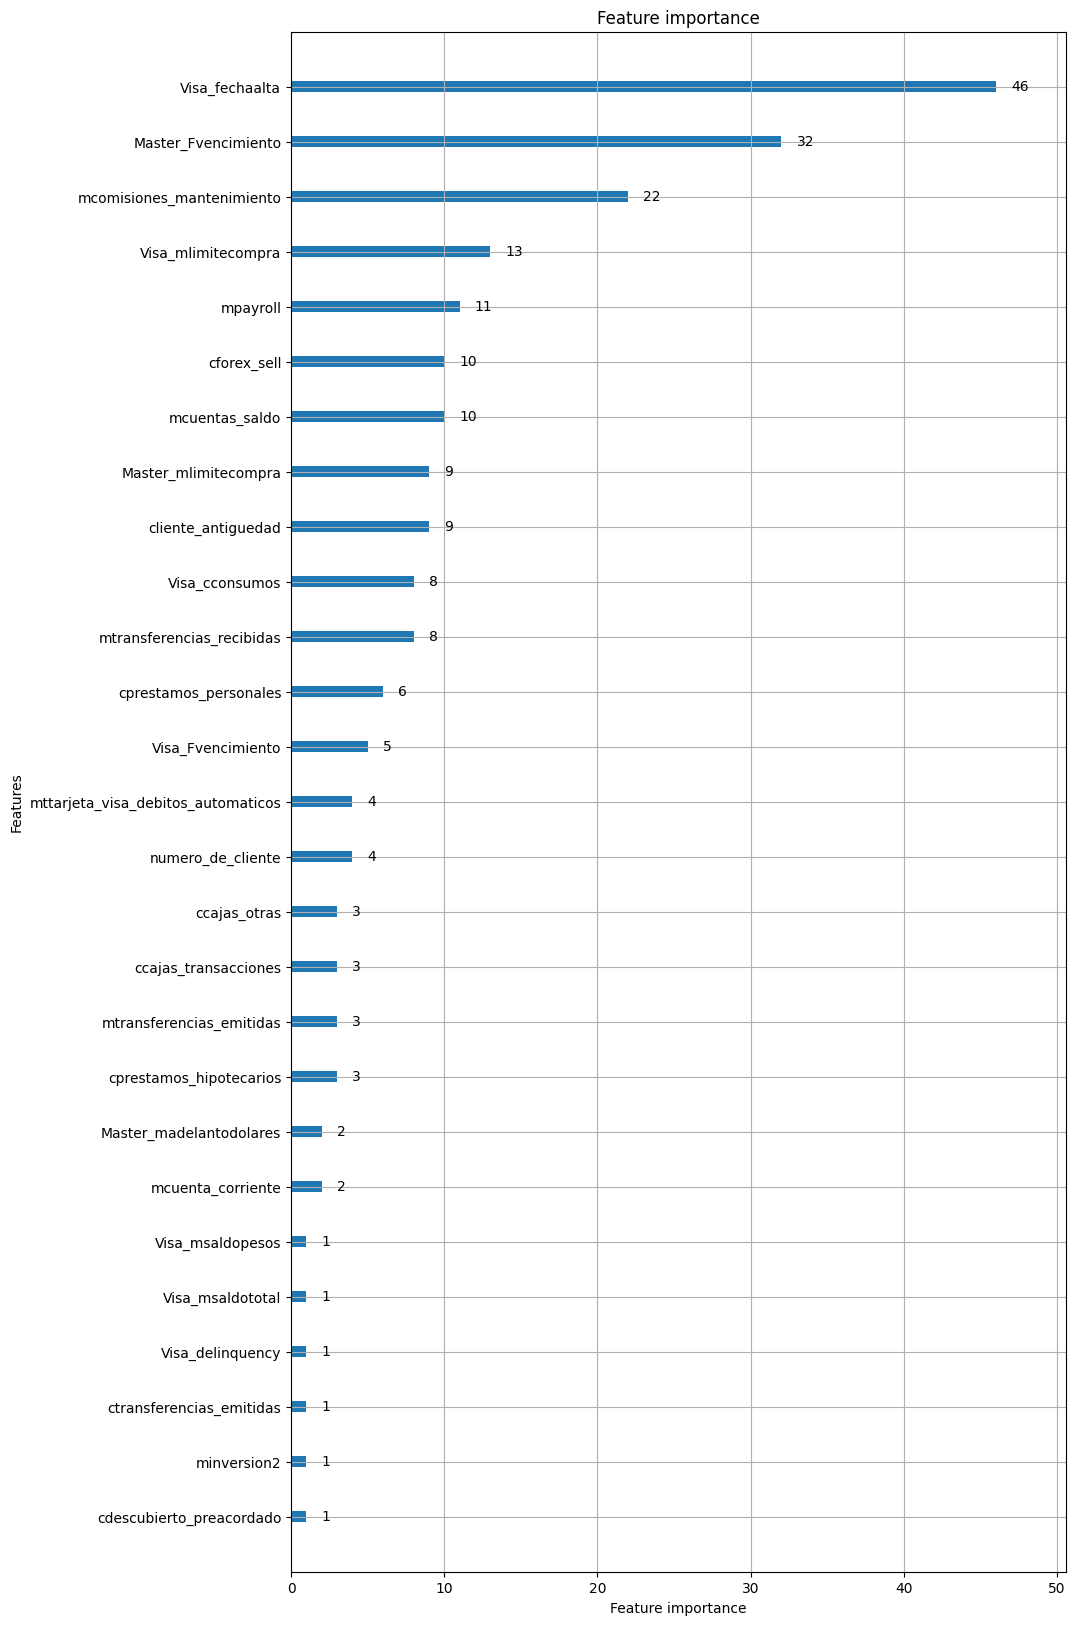

In [28]:
lgb.plot_importance(model_lgb, figsize=(10, 20))
plt.show()


Y si queremos tener las variables más importantes en forma de Dataframe:

In [29]:
#extraccion de feature importances
importances = model_lgb.feature_importance()
features = model_lgb.feature_name() #ian
#creo un dataframe para que sea mas facil de visualizar
importance_df = pd.DataFrame({'feature': features, 'importance': importances})
#ordeno por importancia
importance_df = importance_df.sort_values('importance', ascending=False)

#show.
importance_df.head(100)

,feature,importance
149,Visa_fechaalta,46
113,Master_Fvencimiento,32
72,mcomisiones_mantenimiento,22
142,Visa_mlimitecompra,13
52,mpayroll,11
...,...,...
31,mtarjeta_master_consumo,0
33,mprestamos_personales,0
34,cprestamos_prendarios,0
35,mprestamos_prendarios,0


# Guardar el modelo

In [ ]:
#8. Volvemos a leer el modelo.
#model_lgb = lgb.Booster(model_file= modelos_path + 'lgbm_{}_{}.txt'.format(cantidad_meses_train,ventana))

In [ ]:
#a. Importo librería.
from kaggle.api.kaggle_api_extended import KaggleApi
#b. Configura el API de Kaggle
api = KaggleApi()
api.authenticate()

In [ ]:
import os
import re

# Definimos el patrón de nombre que esperamos para los archivos de modelos
pattern = re.compile(r'^lgb_v5_semilla\d+_\d+_\d+\.txt$') #modificar segun nomrbre de archivo

# Obtén la lista de archivos de modelos en el directorio que coinciden con el patrón
model_files = [f for f in os.listdir(dataset_path) if pattern.match(f)]
print(model_files)

In [ ]:
import time  # Asegúrate de que esta importación está en la parte superior de tu script
# Parámetros de tu competencia y subidas
competencia = 'dm-ey-f-2024-segunda'
num_subida_kaggle = 1

# Bucle sobre cada archivo de modelo
for model_file in model_files:
    # Carga el modelo
    model_path = os.path.join(dataset_path, model_file)
    model_lgb = lgb.Booster(model_file=model_path)
    
    # Copia X_test para evitar añadir múltiples veces la columna 'Probabilidad'
    X_test_copy = X_test.copy()

    # Predecir con el modelo cargado
    predicciones = model_lgb.predict(X_test_copy)
    X_test_copy['Probabilidad'] = predicciones
    tb_entrega = X_test_copy.sort_values(by='Probabilidad', ascending=False)

    # Cortes candidatos y subidas
    cortes = range(9000, 14000, 500)
    for envios in cortes:
        tb_entrega['Predicted'] = 0
        tb_entrega.iloc[:envios, tb_entrega.columns.get_loc('Predicted')] = 1
        resultados = tb_entrega[['numero_de_cliente', 'Predicted']].reset_index(drop=True)
        
        # Extraemos partes del nombre del archivo modelo para personalizar el mensaje y el nombre del archivo de subida
        info_modelo = model_file.replace(".txt", "").split("_")  # Suponiendo nombre como 'lgb_v5_semillaX_Y_Z.txt'
        semilla = info_modelo[2]  # Semilla usada
        mes_train = info_modelo[3]  # Meses de entrenamiento
        ventana = info_modelo[4]  # Ventana de tiempo
        
        nombre_archivo = f"C2_CC_12_dataoriginal_00{num_subida_kaggle}_semilla{semilla}.csv"
        ruta_archivo = f"{exp_path}/{nombre_archivo}"
        resultados.to_csv(ruta_archivo, index=False)
        
        mensaje = f'Archivo {nombre_archivo}. Modelo: semilla{semilla}, meses train {mes_train}, DF {ventana}, dataoriginal,  corte: {envios}'

        
        # Envío a Kaggle
        if num_subida_kaggle <= 15:
            api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
            print("Submission successful!")
        else:
            print("Esperamos 30 segundos...")
            time.sleep(30)
            api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
            print("Submission successful!")
        
        num_subida_kaggle += 1


Ensamble de probabilidades

In [ ]:
import pandas as pd
import numpy as np
import os
import time

# Inicialización de DataFrame para almacenar todas las predicciones
df_predicciones = pd.DataFrame()

# Bucle sobre cada archivo de modelo para cargar y predecir
for model_file in model_files:
    model_path = os.path.join(dataset_path, model_file)
    model_lgb = lgb.Booster(model_file=model_path)
    
    # Predecir con el modelo cargado y almacenar las probabilidades
    predicciones = model_lgb.predict(X_test)
    df_predicciones[model_file] = predicciones

# Calcular la media de las predicciones de todos los modelos
X_test['Probabilidad'] = df_predicciones.mean(axis=1)
tb_entrega = X_test.sort_values(by='Probabilidad', ascending=False)

In [ ]:


# Cortes candidatos y subidas
cortes = range(9000, 14000, 500)
for envios in cortes:
    tb_entrega['Predicted'] = 0
    tb_entrega.iloc[:envios, tb_entrega.columns.get_loc('Predicted')] = 1
    resultados = tb_entrega[['numero_de_cliente', 'Predicted']].reset_index(drop=True)
    
    nombre_archivo = f"C2_CC_12_prueba_00{num_subida_kaggle}.csv"
    ruta_archivo = f"{exp_path}/{nombre_archivo}"
    resultados.to_csv(ruta_archivo, index=False)
    
    mensaje = f'Archivo {nombre_archivo}. Ensamble, DF {ventana}, punto_corte: {envios}.'
    
    # Envío a Kaggle
    if num_subida_kaggle <= 15:
        api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
        print("Submission successful!")
    else:
        print("Esperamos 30 segundos...")
        time.sleep(30)
        api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
        print("Submission successful!")
    
    num_subida_kaggle += 1


In [ ]:
print("Columnas en X_train:", X_train.columns.tolist())
print("Columnas en X_test:", X_test.columns.tolist())
print("Columnas faltantes en X_test:", set(X_train.columns) - set(X_test.columns))
print("Columnas extras en X_test:", set(X_test.columns) - set(X_train.columns))


In [ ]:
# Parámetros de tu competencia y subidas
competencia = 'dm-ey-f-2024-segunda'
num_subida_kaggle = 1

# Bucle sobre cada archivo de modelo
for model_file in model_files:
    # Carga el modelo
    model_path = os.path.join(dataset_path, model_file)
    model_lgb = lgb.Booster(model_file=model_path)
    
    # Predecir con el modelo cargado
    predicciones = model_lgb.predict(X_test)
    X_test['Probabilidad'] = predicciones
    tb_entrega = X_test.sort_values(by='Probabilidad', ascending=False)

    # Cortes candidatos y subidas
    cortes = range(9000, 14000, 500)
    for envios in cortes:
        tb_entrega['Predicted'] = 0
        tb_entrega.iloc[:envios, tb_entrega.columns.get_loc('Predicted')] = 1
        resultados = tb_entrega[['numero_de_cliente', 'Predicted']].reset_index(drop=True)
        
        # Extraemos partes del nombre del archivo modelo para personalizar el mensaje y el nombre del archivo de subida
        info_modelo = model_file.replace(".txt", "").split("_")  # Suponiendo nombre como 'lgb_v5_semillaX_Y_Z.txt'
        semilla = info_modelo[2]  # Semilla usada
        mes_train = info_modelo[3]  # Meses de entrenamiento
        ventana = info_modelo[4]  # Ventana de tiempo
        
        nombre_archivo = f"C2_CC_12_dataoriginal_00{num_subida_kaggle}_semilla{semilla}.csv"
        ruta_archivo = f"{exp_path}/{nombre_archivo}"
        resultados.to_csv(ruta_archivo, index=False)
        
        mensaje = f'Archivo {nombre_archivo}. Modelo: semilla{semilla}, meses train {mes_train}, DF {ventana}, dataoriginal,  corte: {envios}'

        
        # Envío a Kaggle
        if num_subida_kaggle <= 15:
            api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
            print("Submission successful!")
        else:
            print("Esperamos 30 segundos...")
            time.sleep(30)
            api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
            print("Submission successful!")
        
        num_subida_kaggle += 1

[LightGBM] [Fatal] The number of features in data (155) is not the same as it was in training data (154).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.
---------------------------------------------------------------------------
LightGBMError                             Traceback (most recent call last)
Cell In[46], line 12
      9 model_lgb = lgb.Booster(model_file=model_path)
     11 # Predecir con el modelo cargado
---> 12 predicciones = model_lgb.predict(X_test)
     13 X_test['Probabilidad'] = predicciones
     14 tb_entrega = X_test.sort_values(by='Probabilidad', ascending=False)

File ~/.venv/lib/python3.12/site-packages/lightgbm/basic.py:4738, in Booster.predict(self, data, start_iteration, num_iteration, raw_score, pred_leaf, pred_contrib, data_has_header, validate_features, **kwargs)
   4736     else:
   4737         num_iteration = -1
-> 4738 return predictor.predict(
   4739     data=data,
   4740     start_iteration=start_iteration,
   4741     num_iteration=num_iteration,
   4742     raw_score=raw_score,
   4743     pred_leaf=pred_leaf,
   4744     pred_contrib=pred_contrib,
   4745     data_has_header=data_has_header,
   4746     validate_features=validate_features,
   4747 )

File ~/.venv/lib/python3.12/site-packages/lightgbm/basic.py:1183, in _InnerPredictor.predict(self, data, start_iteration, num_iteration, raw_score, pred_leaf, pred_contrib, data_has_header, validate_features)
   1176     preds, nrow = self.__pred_for_csc(
   1177         csc=data,
   1178         start_iteration=start_iteration,
   1179         num_iteration=num_iteration,
   1180         predict_type=predict_type,
   1181     )
   1182 elif isinstance(data, np.ndarray):
-> 1183     preds, nrow = self.__pred_for_np2d(
   1184         mat=data,
   1185         start_iteration=start_iteration,
   1186         num_iteration=num_iteration,
   1187         predict_type=predict_type,
   1188     )
   1189 elif _is_pyarrow_table(data):
   1190     preds, nrow = self.__pred_for_pyarrow_table(
   1191         table=data,
   1192         start_iteration=start_iteration,
   1193         num_iteration=num_iteration,
   1194         predict_type=predict_type,
   1195     )

File ~/.venv/lib/python3.12/site-packages/lightgbm/basic.py:1342, in _InnerPredictor.__pred_for_np2d(self, mat, start_iteration, num_iteration, predict_type)
   1340     return preds, nrow
   1341 else:
-> 1342     return self.__inner_predict_np2d(
   1343         mat=mat,
   1344         start_iteration=start_iteration,
   1345         num_iteration=num_iteration,
   1346         predict_type=predict_type,
   1347         preds=None,
   1348     )

File ~/.venv/lib/python3.12/site-packages/lightgbm/basic.py:1288, in _InnerPredictor.__inner_predict_np2d(self, mat, start_iteration, num_iteration, predict_type, preds)
   1286     raise ValueError("Wrong length of pre-allocated predict array")
   1287 out_num_preds = ctypes.c_int64(0)
-> 1288 _safe_call(
   1289     _LIB.LGBM_BoosterPredictForMat(
   1290         self._handle,
   1291         ptr_data,
   1292         ctypes.c_int(type_ptr_data),
   1293         ctypes.c_int32(mat.shape[0]),
   1294         ctypes.c_int32(mat.shape[1]),
   1295         ctypes.c_int(_C_API_IS_ROW_MAJOR),
   1296         ctypes.c_int(predict_type),
   1297         ctypes.c_int(start_iteration),
   1298         ctypes.c_int(num_iteration),
   1299         _c_str(self.pred_parameter),
   1300         ctypes.byref(out_num_preds),
   1301         preds.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
   1302     )
   1303 )
   1304 if n_preds != out_num_preds.value:
   1305     raise ValueError("Wrong length for predict results")

File ~/.venv/lib/python3.12/site-packages/lightgbm/basic.py:294, in _safe_call(ret)
    286 """Check the return value from C API call.
    287 
    288 Parameters
   (...)
    291     The return value from C API calls.
    292 """
    293 if ret != 0:
--> 294     raise LightGBMError(_LIB.LGBM_GetLastError().decode("utf-8"))

LightGBMError: The number of features in data (155) is not the same as it was in training data (154).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.